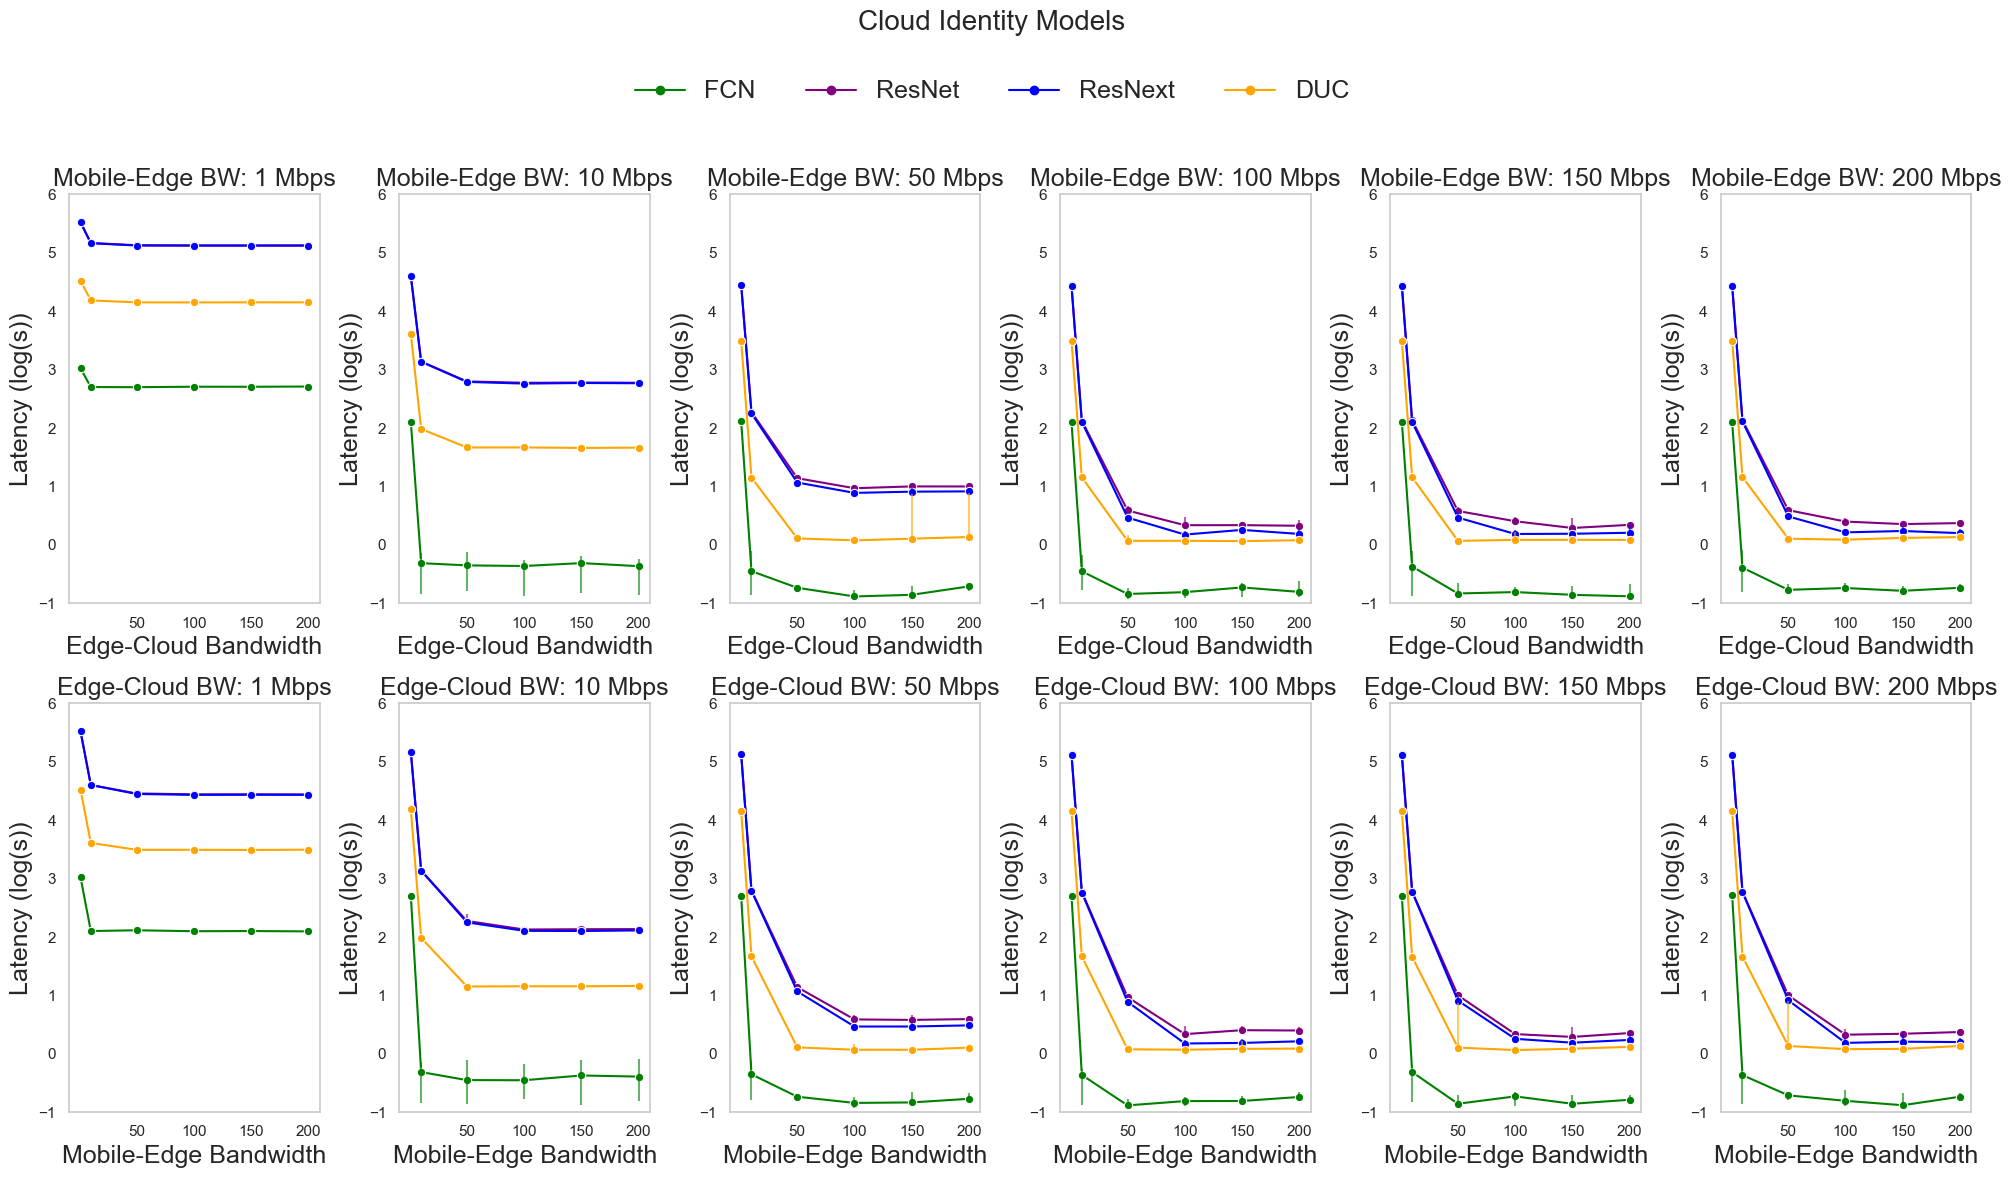

In [9]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn": "cloud_fcn",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet": "cloud_resnet",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext": "cloud_resnext",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc":"cloud_duc",
}

# Models to process
models = ["cloud_fcn", "cloud_resnet","cloud_resnext","cloud_duc"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[2].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[3].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn": "green",
    "cloud_resnet": "purple",
    "cloud_resnext":"blue",
    "cloud_duc":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn": "FCN",
    "cloud_resnet": "ResNet",
    "cloud_resnext":"ResNext",
    "cloud_duc":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud Identity Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
plt.savefig('cloud_latency_identity.png', dpi=300)
fig.savefig('cloud_latency_identity.pdf', bbox_inches='tight',format='pdf')
plt.show()

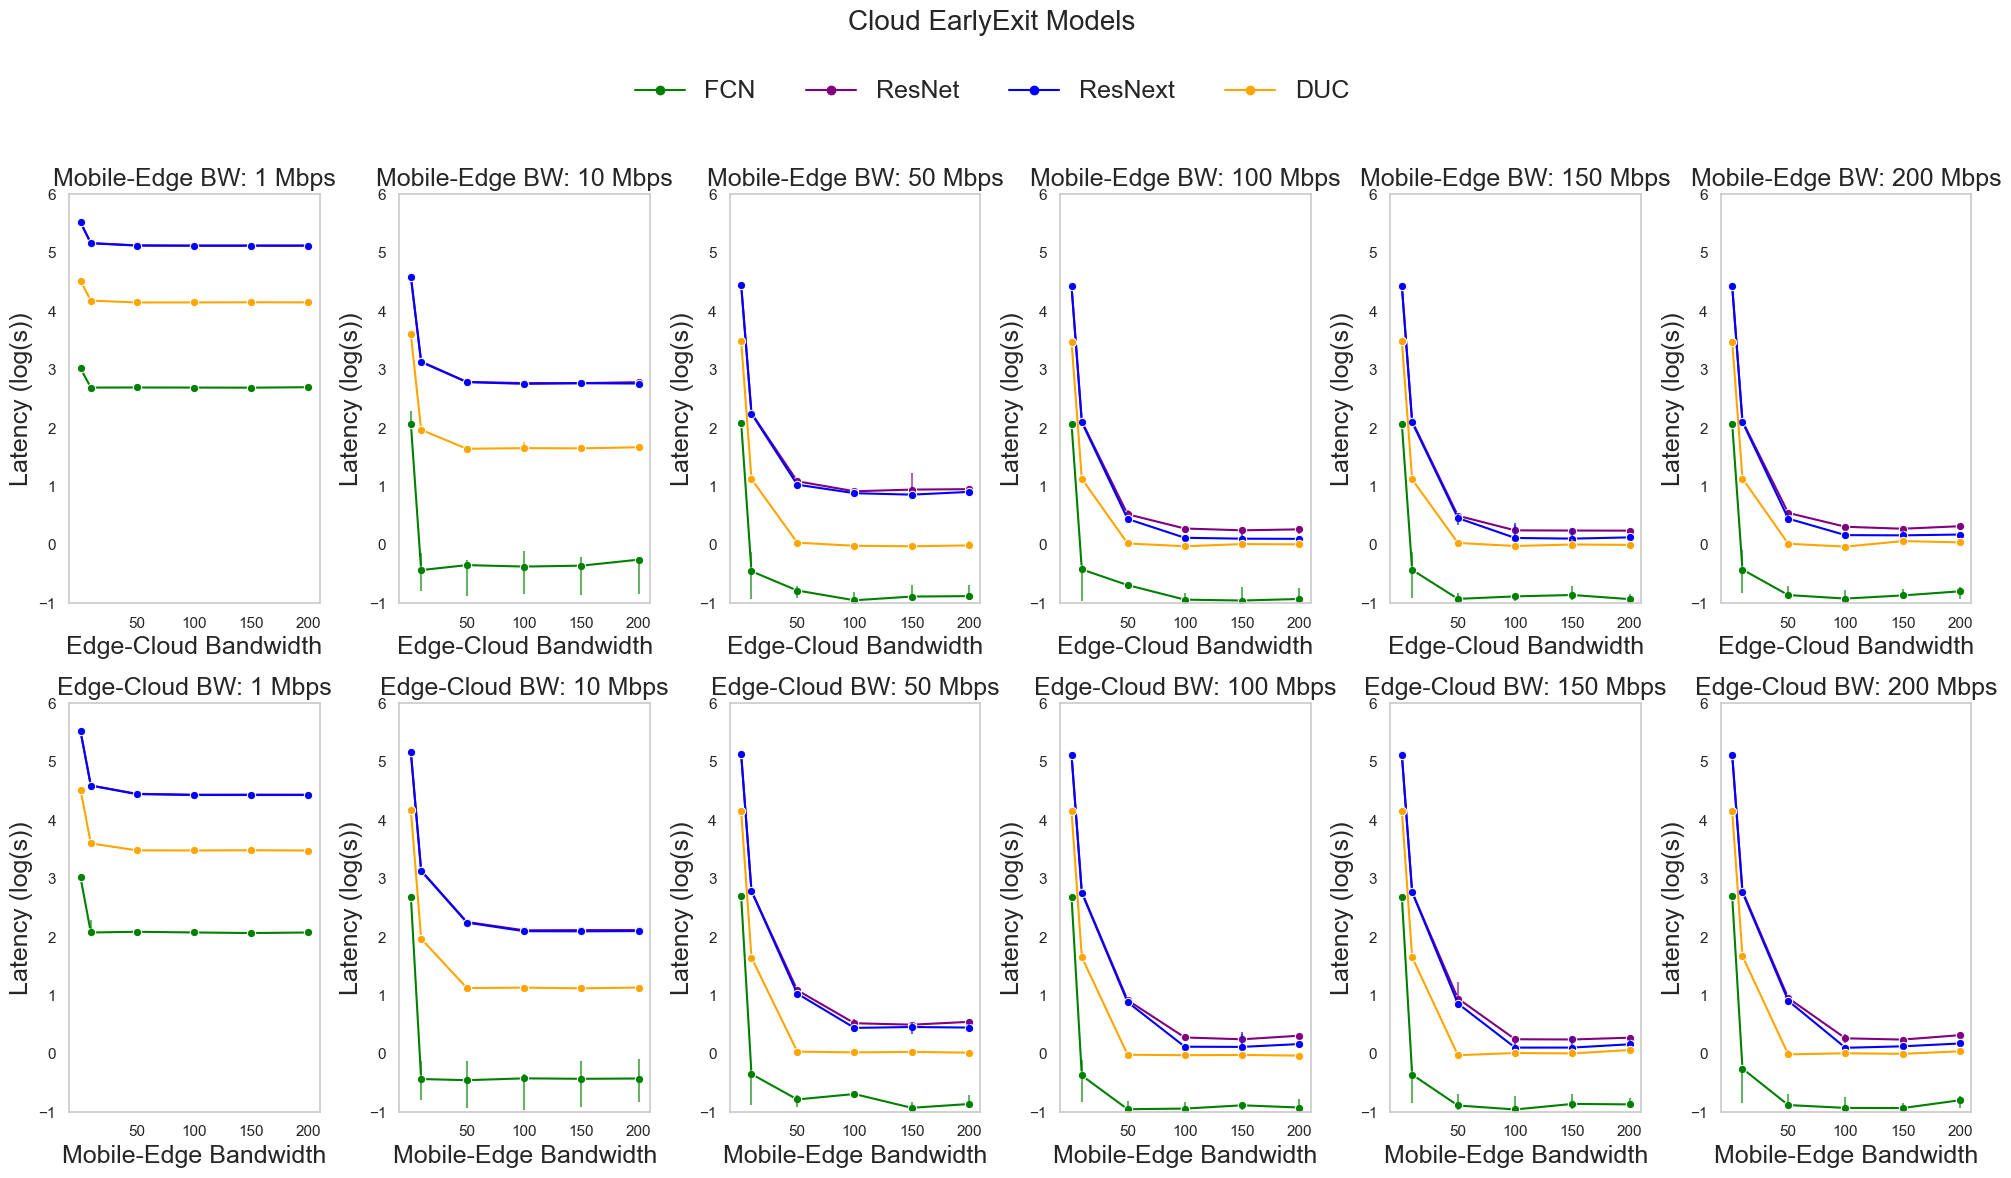

In [10]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_earlyexit": "cloud_fcn_earlyexit",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_earlyexit": "cloud_resnet_earlyexit",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_earlyexit": "cloud_resnext_earlyexit",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_earlyexit":"cloud_duc_earlyexit",
}

# Models to process
models = ["cloud_fcn_earlyexit", "cloud_resnet_earlyexit","cloud_resnext_earlyexit","cloud_duc_earlyexit"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[3].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[4].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_earlyexit": "green",
    "cloud_resnet_earlyexit": "purple",
    "cloud_resnext_earlyexit":"blue",
    "cloud_duc_earlyexit":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_earlyexit": "FCN",
    "cloud_resnet_earlyexit": "ResNet",
    "cloud_resnext_earlyexit":"ResNext",
    "cloud_duc_earlyexit":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud EarlyExit Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('cloud_latency_earlyexit.pdf', bbox_inches='tight',format='pdf')
plt.savefig('cloud_latency_earlyexit.png', dpi=300)
plt.show()

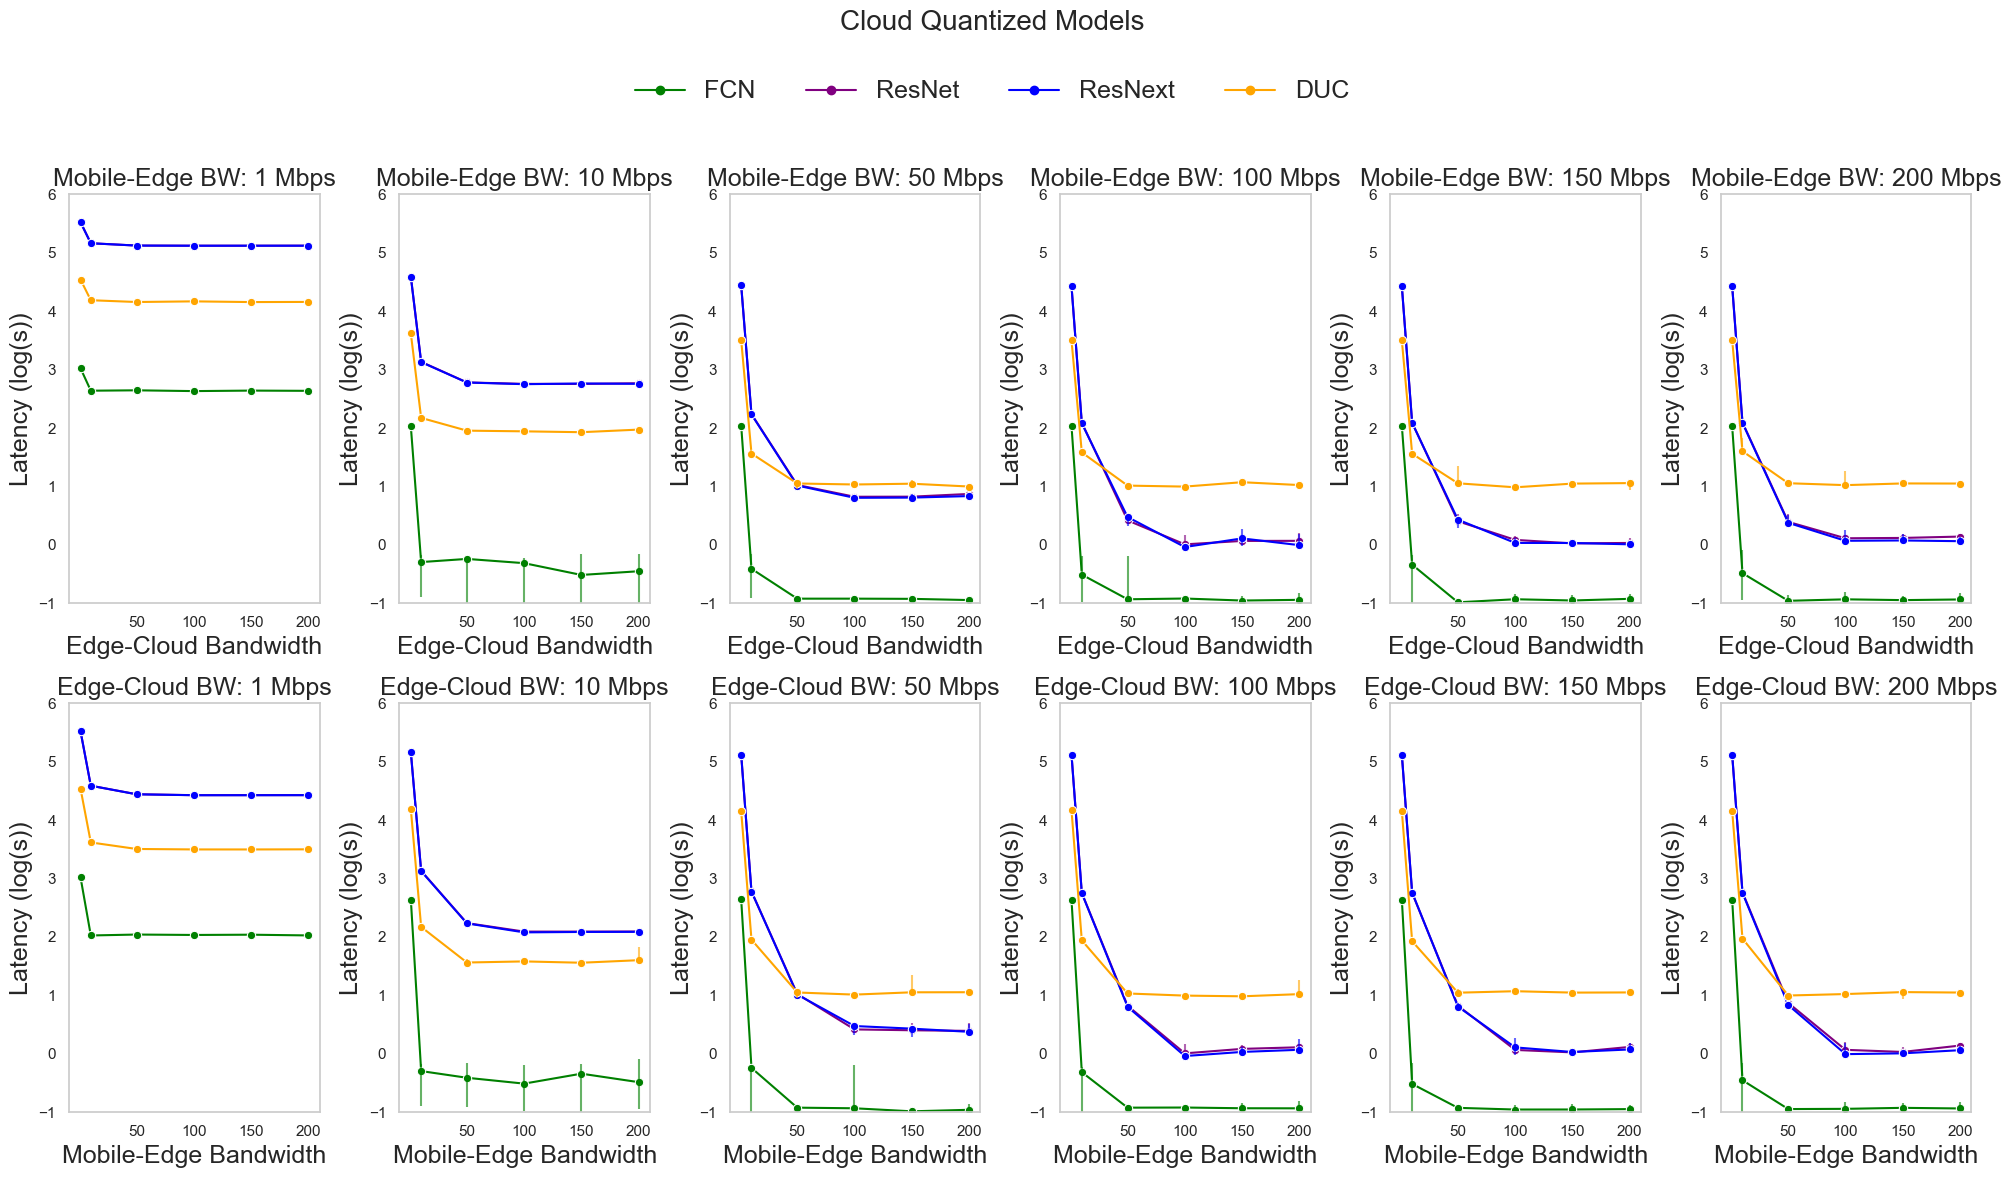

In [11]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_int8_sptq": "cloud_fcn_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_int8_sptq": "cloud_resnet_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_int8_sptq": "cloud_resnext_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_int8_sptq":"cloud_duc_int8_sptq",
}

# Models to process
models = ["cloud_fcn_int8_sptq", "cloud_resnet_int8_sptq","cloud_resnext_int8_sptq","cloud_duc_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[4].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[5].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_int8_sptq": "green",
    "cloud_resnet_int8_sptq": "purple",
    "cloud_resnext_int8_sptq":"blue",
    "cloud_duc_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_int8_sptq": "FCN",
    "cloud_resnet_int8_sptq": "ResNet",
    "cloud_resnext_int8_sptq":"ResNext",
    "cloud_duc_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-1, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth', fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud Quantized Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False, fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('cloud_latency_int8_sptq.pdf', bbox_inches='tight',format='pdf')
plt.savefig('cloud_latency_int8_sptq.png', dpi=300)
plt.show()

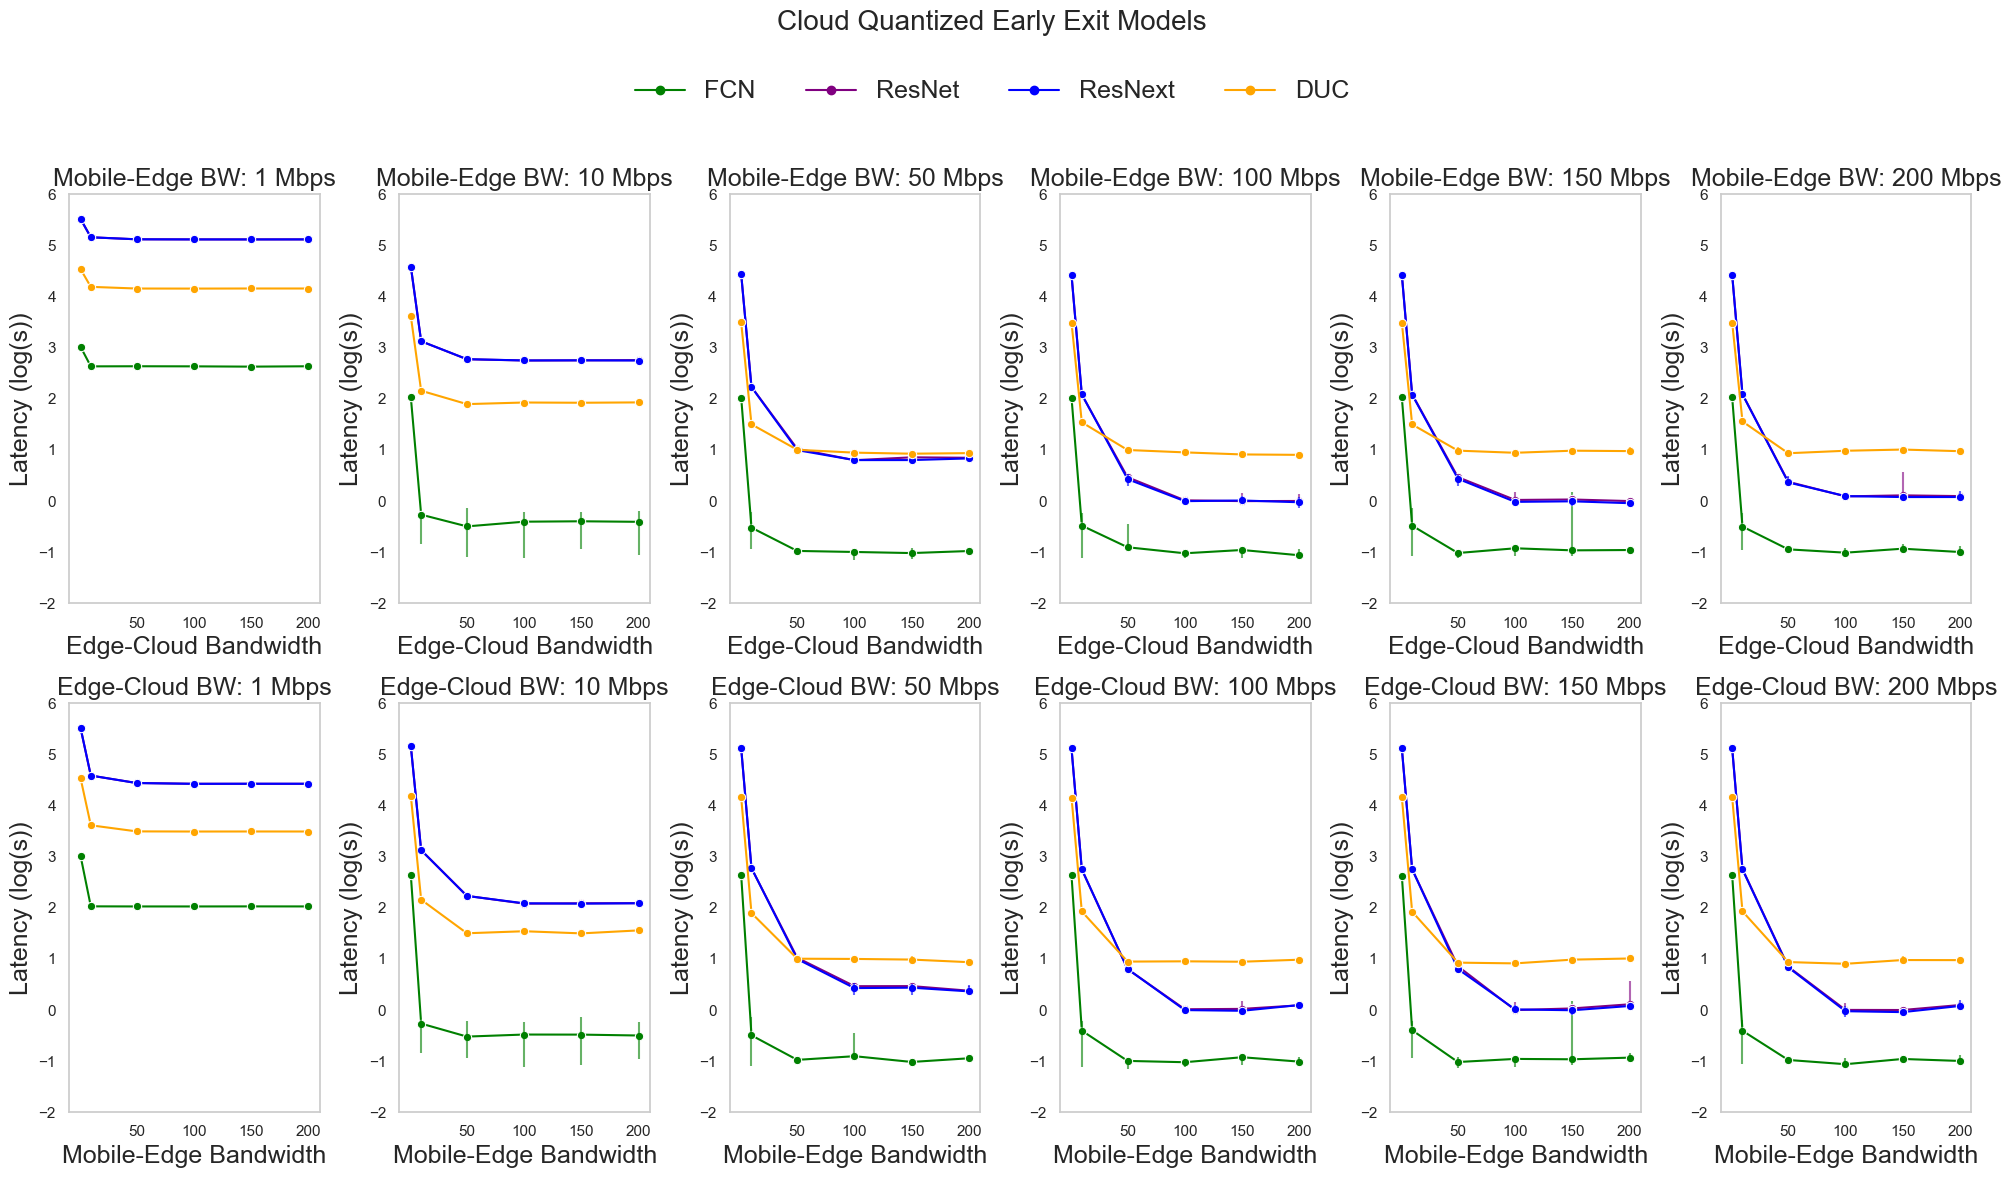

In [12]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_earlyexit_int8_sptq": "cloud_fcn_earlyexit_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_earlyexit_int8_sptq": "cloud_resnet_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_earlyexit_int8_sptq": "cloud_resnext_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_earlyexit_int8_sptq":"cloud_duc_earlyexit_int8_sptq",
}

# Models to process
models = ["cloud_fcn_earlyexit_int8_sptq", "cloud_resnet_earlyexit_int8_sptq","cloud_resnext_earlyexit_int8_sptq","cloud_duc_earlyexit_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[5].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[6].replace("mbps", ""))  # Extract edge  cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_earlyexit_int8_sptq": "green",
    "cloud_resnet_earlyexit_int8_sptq": "purple",
    "cloud_resnext_earlyexit_int8_sptq":"blue",
    "cloud_duc_earlyexit_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_earlyexit_int8_sptq": "FCN",
    "cloud_resnet_earlyexit_int8_sptq": "ResNet",
    "cloud_resnext_earlyexit_int8_sptq":"ResNext",
    "cloud_duc_earlyexit_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-2, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(-2, 6)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud Quantized Early Exit Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('cloud_latency_earlyexit_int8_sptq.pdf', bbox_inches='tight',format='pdf')
plt.savefig('cloud_latency_earlyexit_int8_sptq.png', dpi=300)
plt.show()

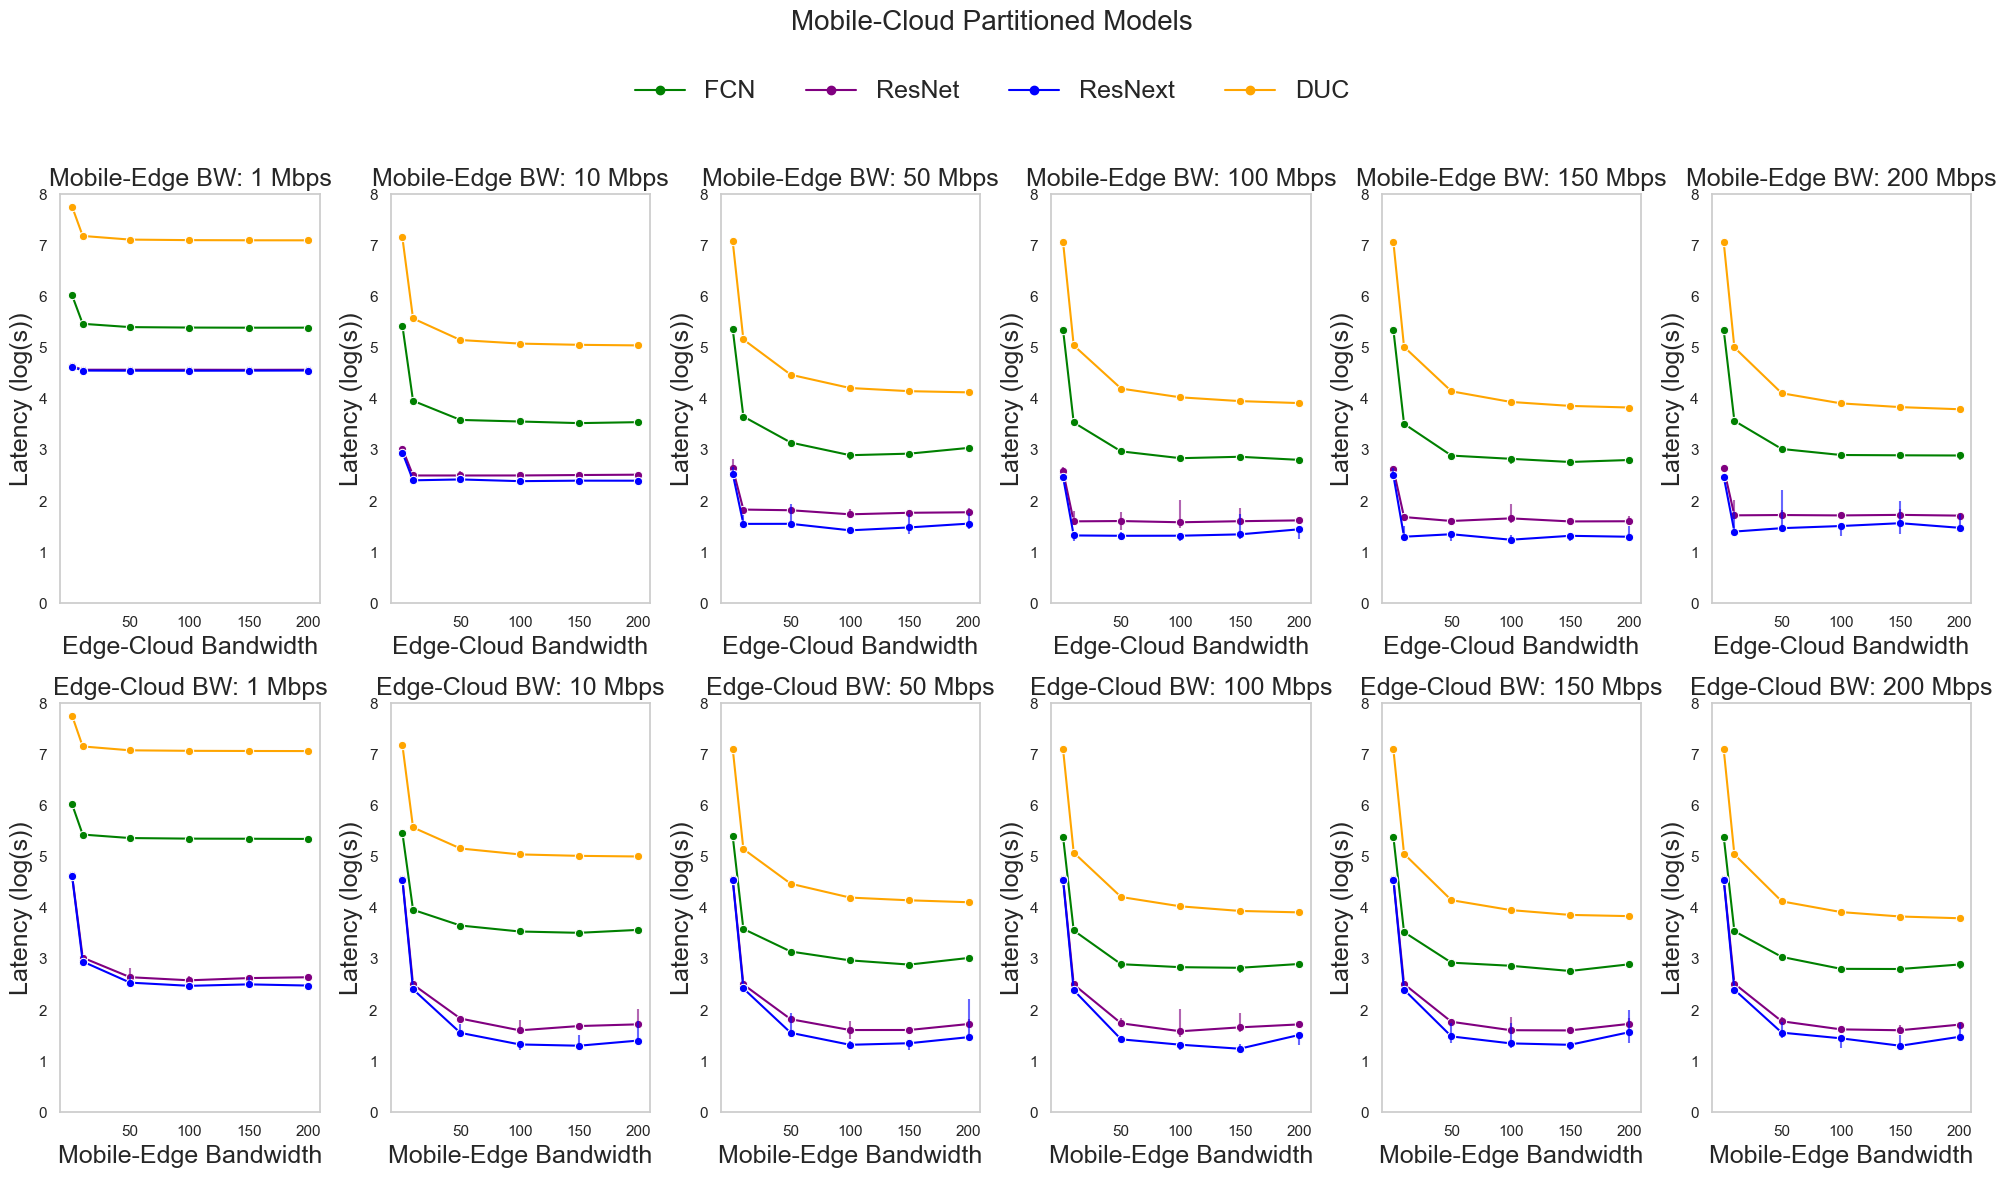

In [13]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_cloud_fcn": "mobile_cloud_fcn",      # <-- Replace with the actual path for cloud_fcn
    "mobile_cloud_resnet": "mobile_cloud_resnet",  # <-- Replace with the actual path for cloud_resnet
    "mobile_cloud_resnext": "mobile_cloud_resnext",  # <-- Replace with the actual path for cloud_resnext
    "mobile_cloud_duc":"mobile_cloud_duc",
}

# Models to process
models = ["mobile_cloud_fcn", "mobile_cloud_resnet","mobile_cloud_resnext","mobile_cloud_duc"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[3].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[4].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "mobile_cloud_fcn": "green",
    "mobile_cloud_resnet": "purple",
    "mobile_cloud_resnext":"blue",
    "mobile_cloud_duc":"orange",
}

# Simplified model names for legend
legend_labels = {
    "mobile_cloud_fcn": "FCN",
    "mobile_cloud_resnet": "ResNet",
    "mobile_cloud_resnext":"ResNext",
    "mobile_cloud_duc":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Mobile-Cloud Partitioned Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('mobile_cloud_partition_latency.pdf', bbox_inches='tight',format='pdf')
plt.savefig('mobile_cloud_partition_latency.png', dpi=300)
plt.show()

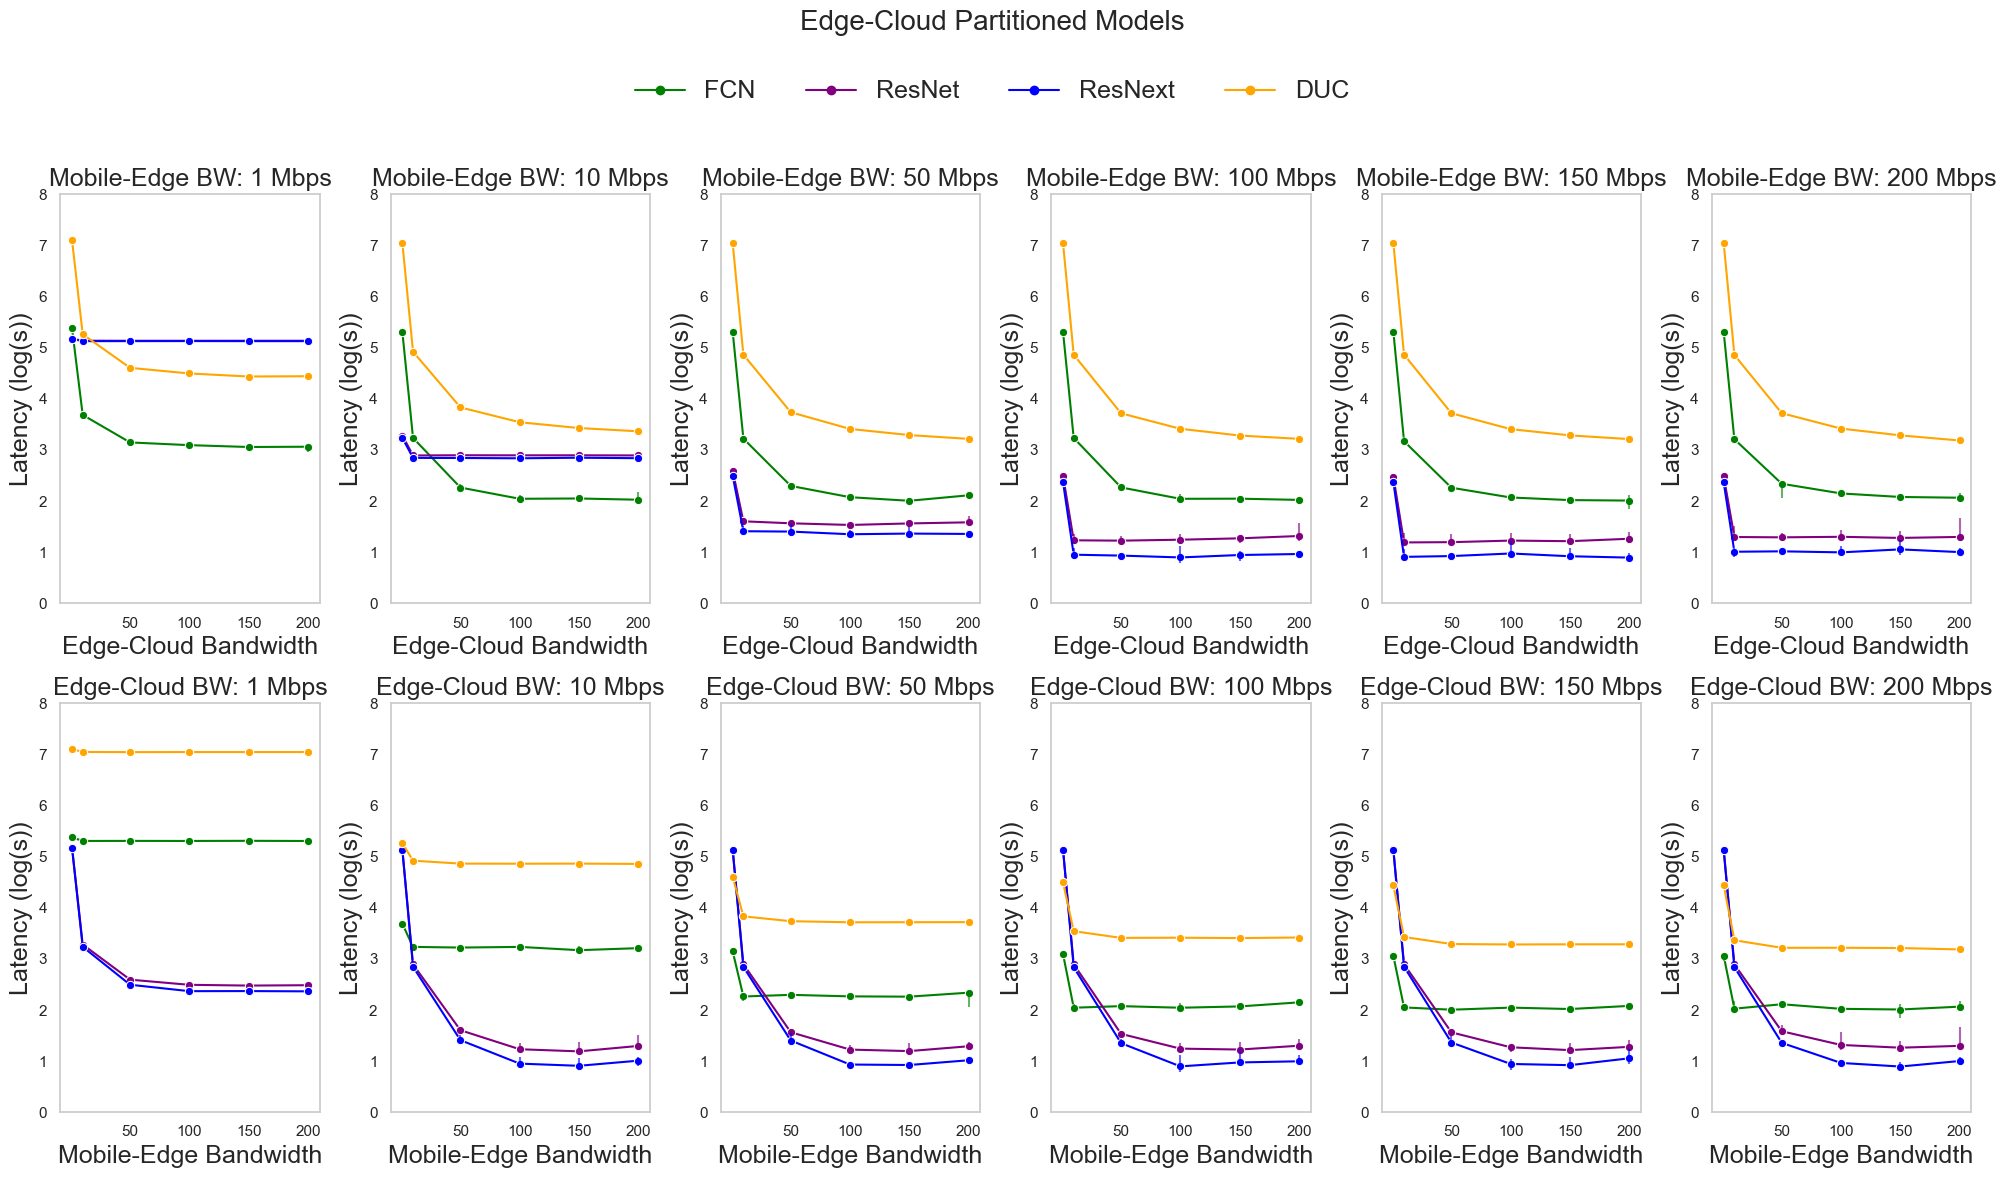

In [14]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "edge_cloud_fcn": "edge_cloud_fcn",      # <-- Replace with the actual path for cloud_fcn
    "edge_cloud_resnet": "edge_cloud_resnet",  # <-- Replace with the actual path for cloud_resnet
    "edge_cloud_resnext": "edge_cloud_resnext",  # <-- Replace with the actual path for cloud_resnext
    "edge_cloud_duc":"edge_cloud_duc",
}

# Models to process
models = ["edge_cloud_fcn", "edge_cloud_resnet","edge_cloud_resnext","edge_cloud_duc"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[3].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[4].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "edge_cloud_fcn": "green",
    "edge_cloud_resnet": "purple",
    "edge_cloud_resnext":"blue",
    "edge_cloud_duc":"orange",
}

# Simplified model names for legend
legend_labels = {
    "edge_cloud_fcn": "FCN",
    "edge_cloud_resnet": "ResNet",
    "edge_cloud_resnext":"ResNext",
    "edge_cloud_duc":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Edge-Cloud Partitioned Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('edge_cloud_partition_latency.pdf', bbox_inches='tight',format='pdf')
plt.savefig('edge_cloud_partition_latency.png', dpi=300)
plt.show()

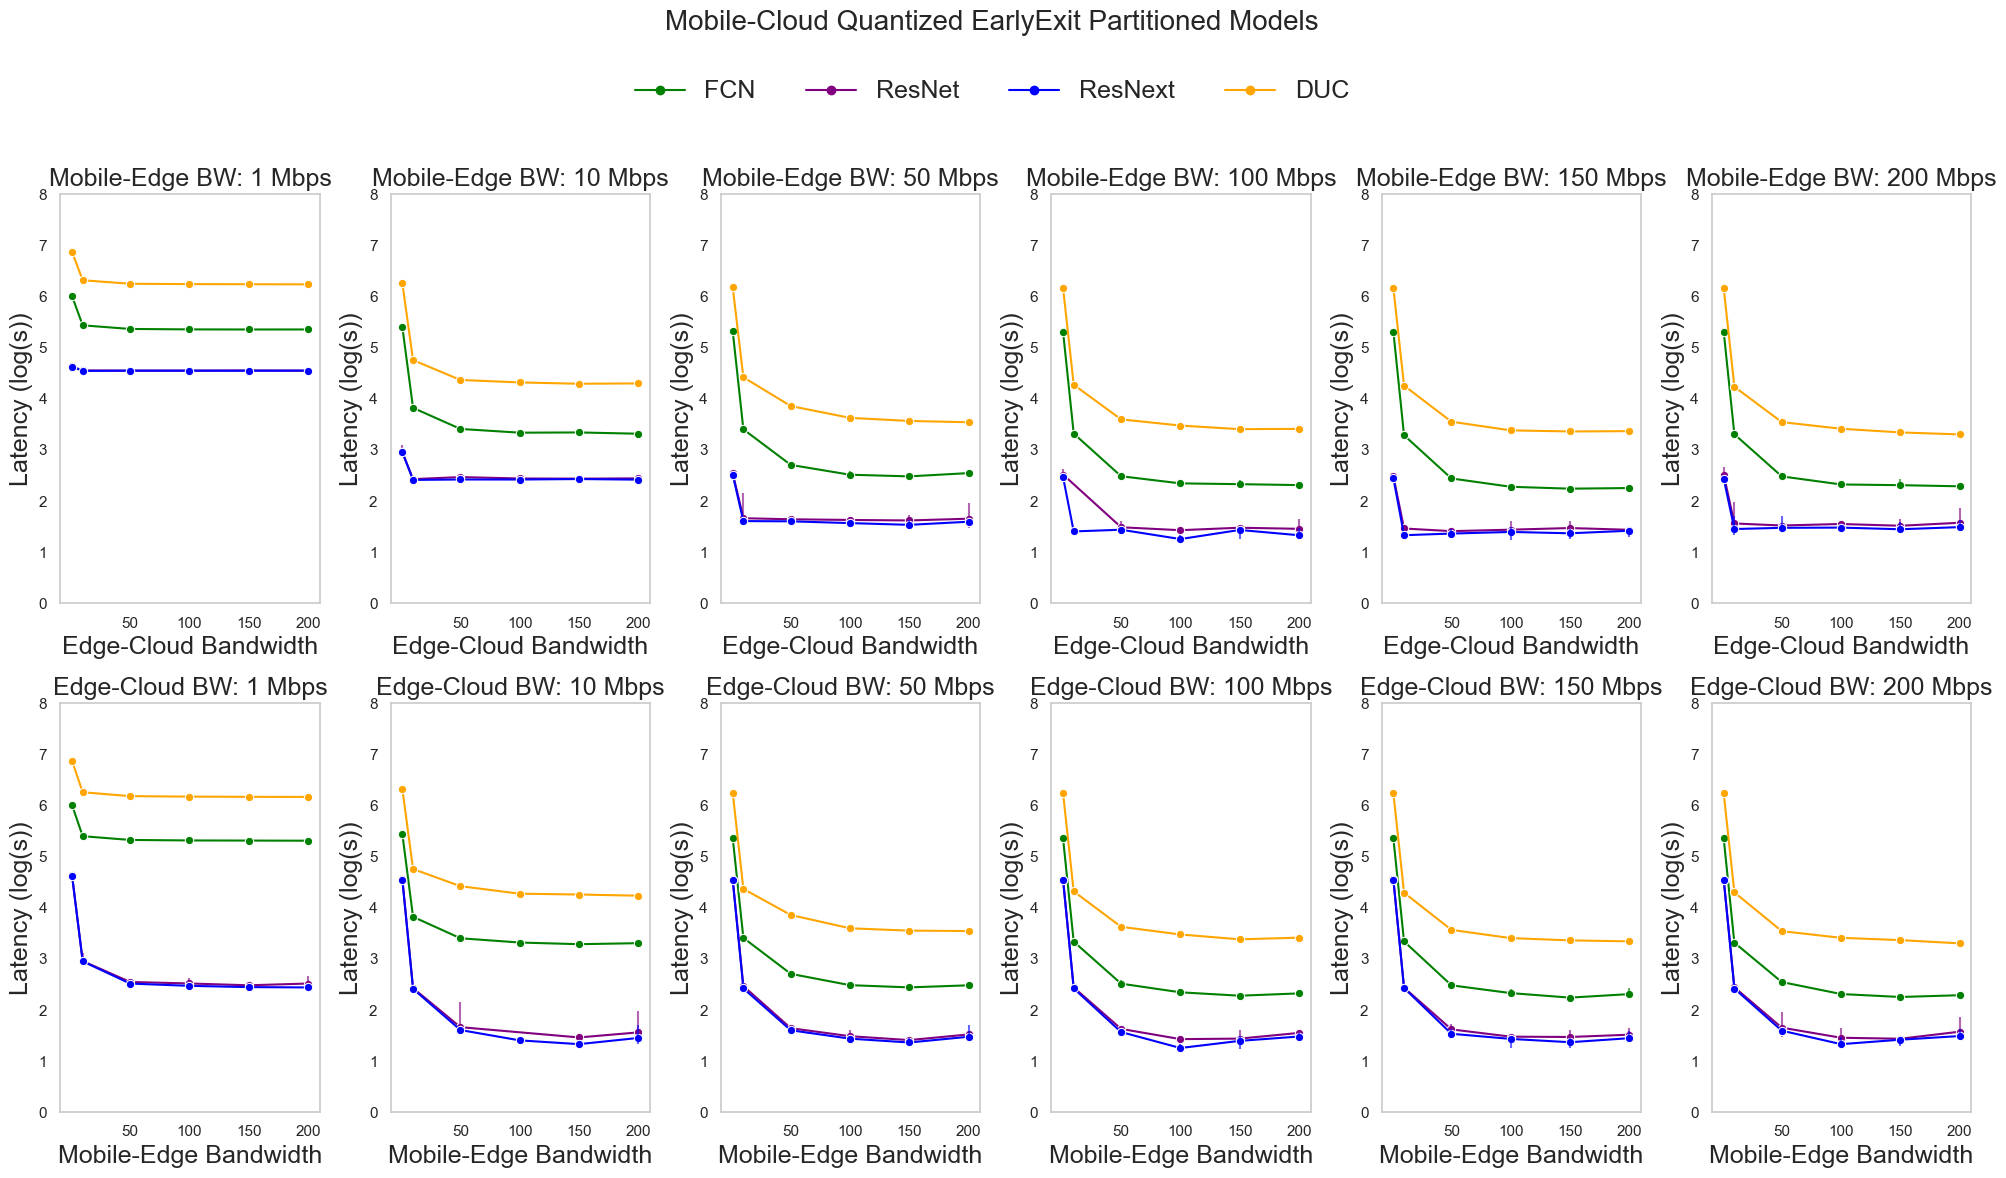

In [15]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_cloud_fcn_earlyexit_int8_sptq": "mobile_cloud_fcn_earlyexit_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "mobile_cloud_resnet_earlyexit_int8_sptq": "mobile_cloud_resnet_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "mobile_cloud_resnext_earlyexit_int8_sptq": "mobile_cloud_resnext_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "mobile_cloud_duc_earlyexit_int8_sptq":"mobile_cloud_duc_earlyexit_int8_sptq",
}

# Models to process
models = ["mobile_cloud_fcn_earlyexit_int8_sptq", "mobile_cloud_resnet_earlyexit_int8_sptq","mobile_cloud_resnext_earlyexit_int8_sptq","mobile_cloud_duc_earlyexit_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[6].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[7].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "mobile_cloud_fcn_earlyexit_int8_sptq": "green",
    "mobile_cloud_resnet_earlyexit_int8_sptq": "purple",
    "mobile_cloud_resnext_earlyexit_int8_sptq":"blue",
    "mobile_cloud_duc_earlyexit_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "mobile_cloud_fcn_earlyexit_int8_sptq": "FCN",
    "mobile_cloud_resnet_earlyexit_int8_sptq": "ResNet",
    "mobile_cloud_resnext_earlyexit_int8_sptq":"ResNext",
    "mobile_cloud_duc_earlyexit_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 8)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Mobile-Cloud Quantized EarlyExit Partitioned Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('mobile_cloud_quantized_earlyexit_partition_latency.pdf', bbox_inches='tight',format='pdf')
plt.savefig('mobile_cloud_quantized_earlyexit_partition_latency.png', dpi=300)
plt.show()

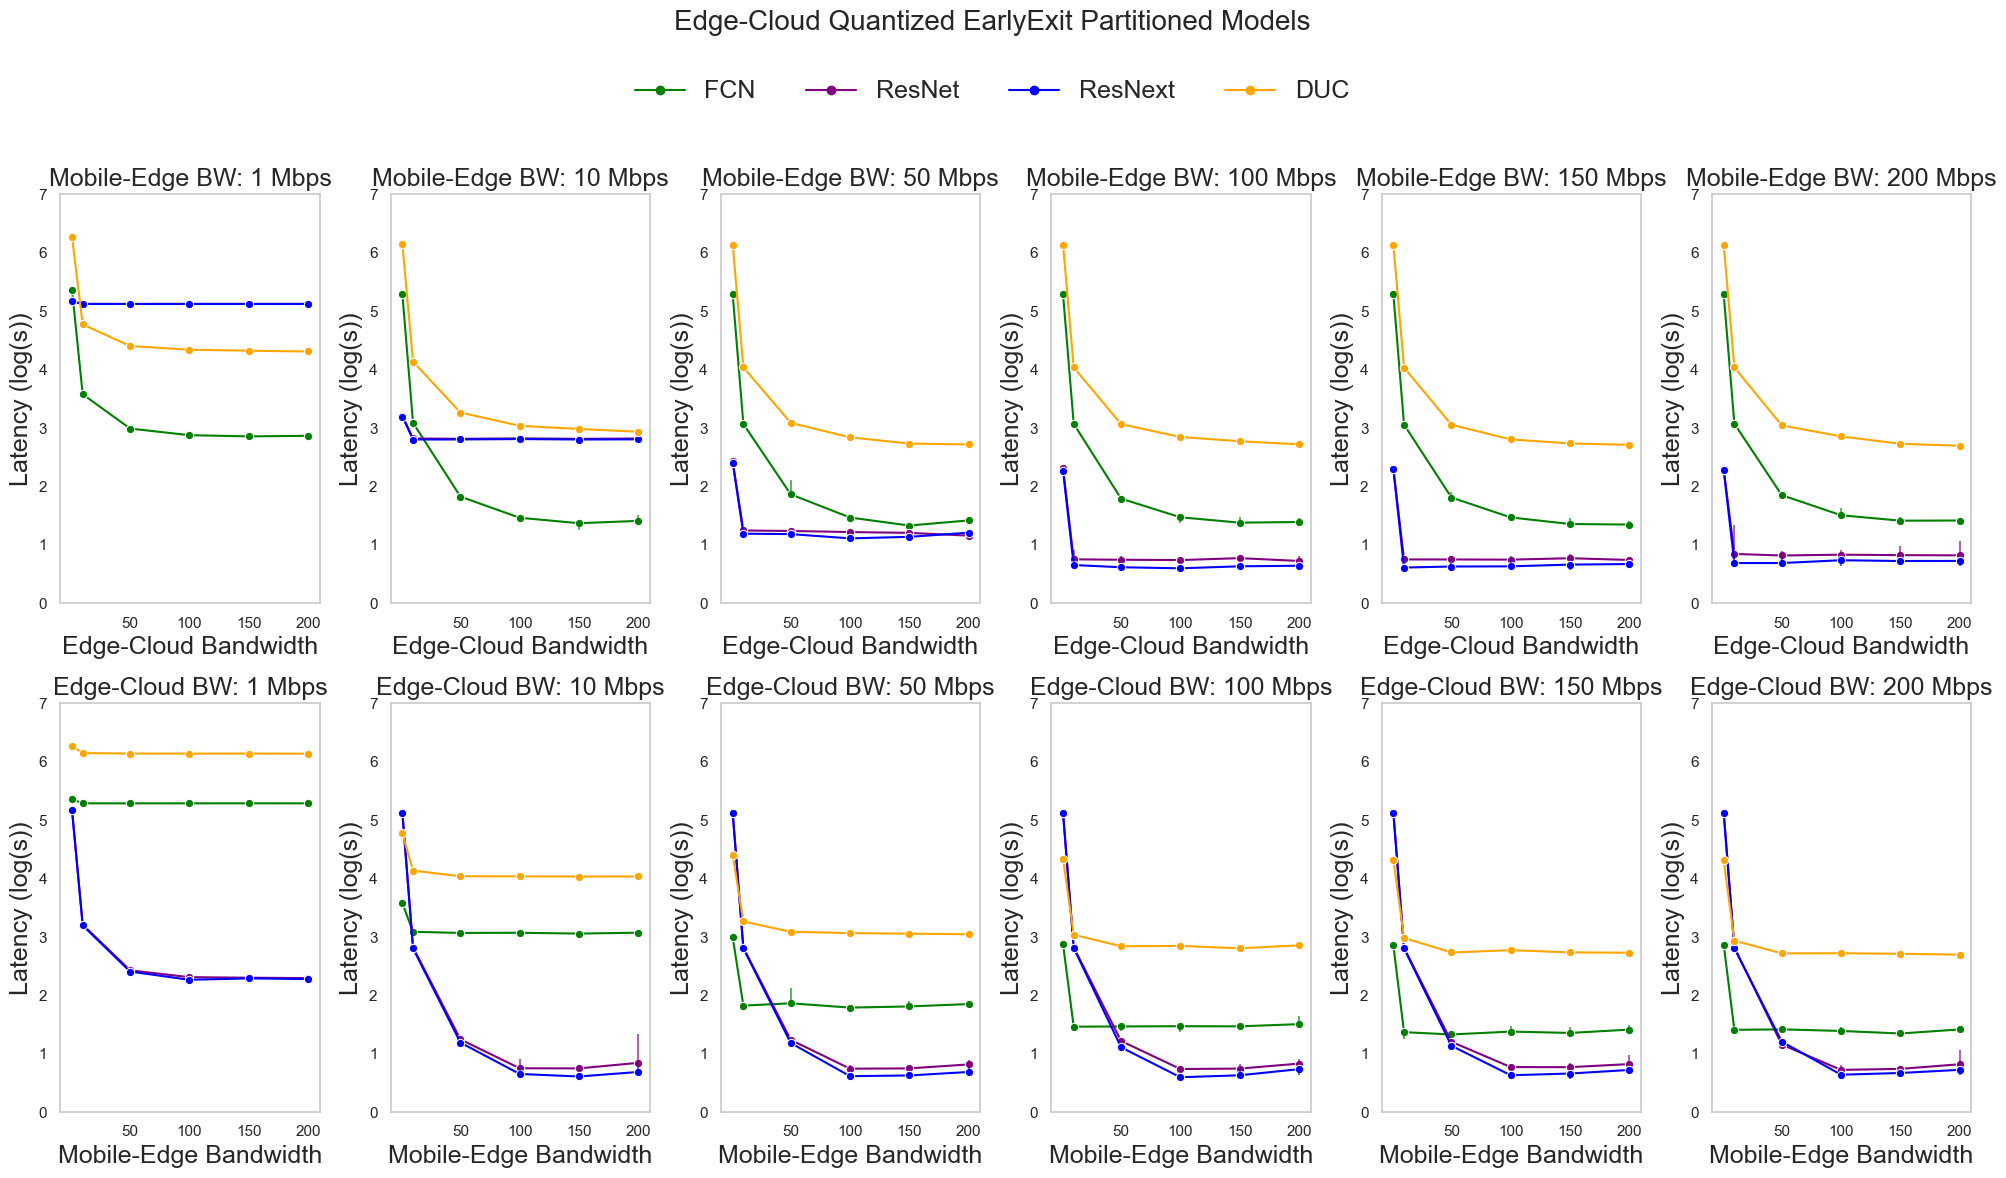

In [16]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        latencies = [float(line.split("\n")[0]) for line in lines if '\n' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "edge_cloud_fcn_earlyexit_int8_sptq": "edge_cloud_fcn_earlyexit_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "edge_cloud_resnet_earlyexit_int8_sptq": "edge_cloud_resnet_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "edge_cloud_resnext_earlyexit_int8_sptq": "edge_cloud_resnext_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "edge_cloud_duc_earlyexit_int8_sptq":"edge_cloud_duc_earlyexit_int8_sptq",
}

# Models to process
models = ["edge_cloud_fcn_earlyexit_int8_sptq", "edge_cloud_resnet_earlyexit_int8_sptq","edge_cloud_resnext_earlyexit_int8_sptq","edge_cloud_duc_earlyexit_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[6].replace("mbps", ""))  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[7].replace("mbps", ""))   # Extract edge cloud bandwidth
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "edge_cloud_fcn_earlyexit_int8_sptq": "green",
    "edge_cloud_resnet_earlyexit_int8_sptq": "purple",
    "edge_cloud_resnext_earlyexit_int8_sptq":"blue",
    "edge_cloud_duc_earlyexit_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "edge_cloud_fcn_earlyexit_int8_sptq": "FCN",
    "edge_cloud_resnet_earlyexit_int8_sptq": "ResNet",
    "edge_cloud_resnext_earlyexit_int8_sptq":"ResNext",
    "edge_cloud_duc_earlyexit_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 6, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.log(np.median(samples)) for samples in latencies]
            mins = [np.log(np.min(samples)) for samples in latencies]
            maxs = [np.log(np.max(samples)) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 7)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps',fontsize=18)
    ax.grid(False)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.log(np.median(latencies))
                min_latency = np.log(np.min(latencies))
                max_latency = np.log(np.max(latencies))
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    ax.set_xticks([50, 100, 150, 200])
    ax.set_ylim(0, 7)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth',fontsize=18)
    ax.set_ylabel('Latency (log(s))',fontsize=18)
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps',fontsize=18)
    ax.grid(False)

# Adjust layout and leave space for the legend
fig.suptitle('Edge-Cloud Quantized EarlyExit Partitioned Models', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False,fontsize=18)  # Move the legend slightly lower
# Save the figure as a single image
fig.savefig('edge_cloud_quantized_earlyexit_partition_latency.pdf', bbox_inches='tight',format='pdf')
plt.savefig('edge_cloud_quantized_earlyexit_partition_latency.png', dpi=300)
plt.show()

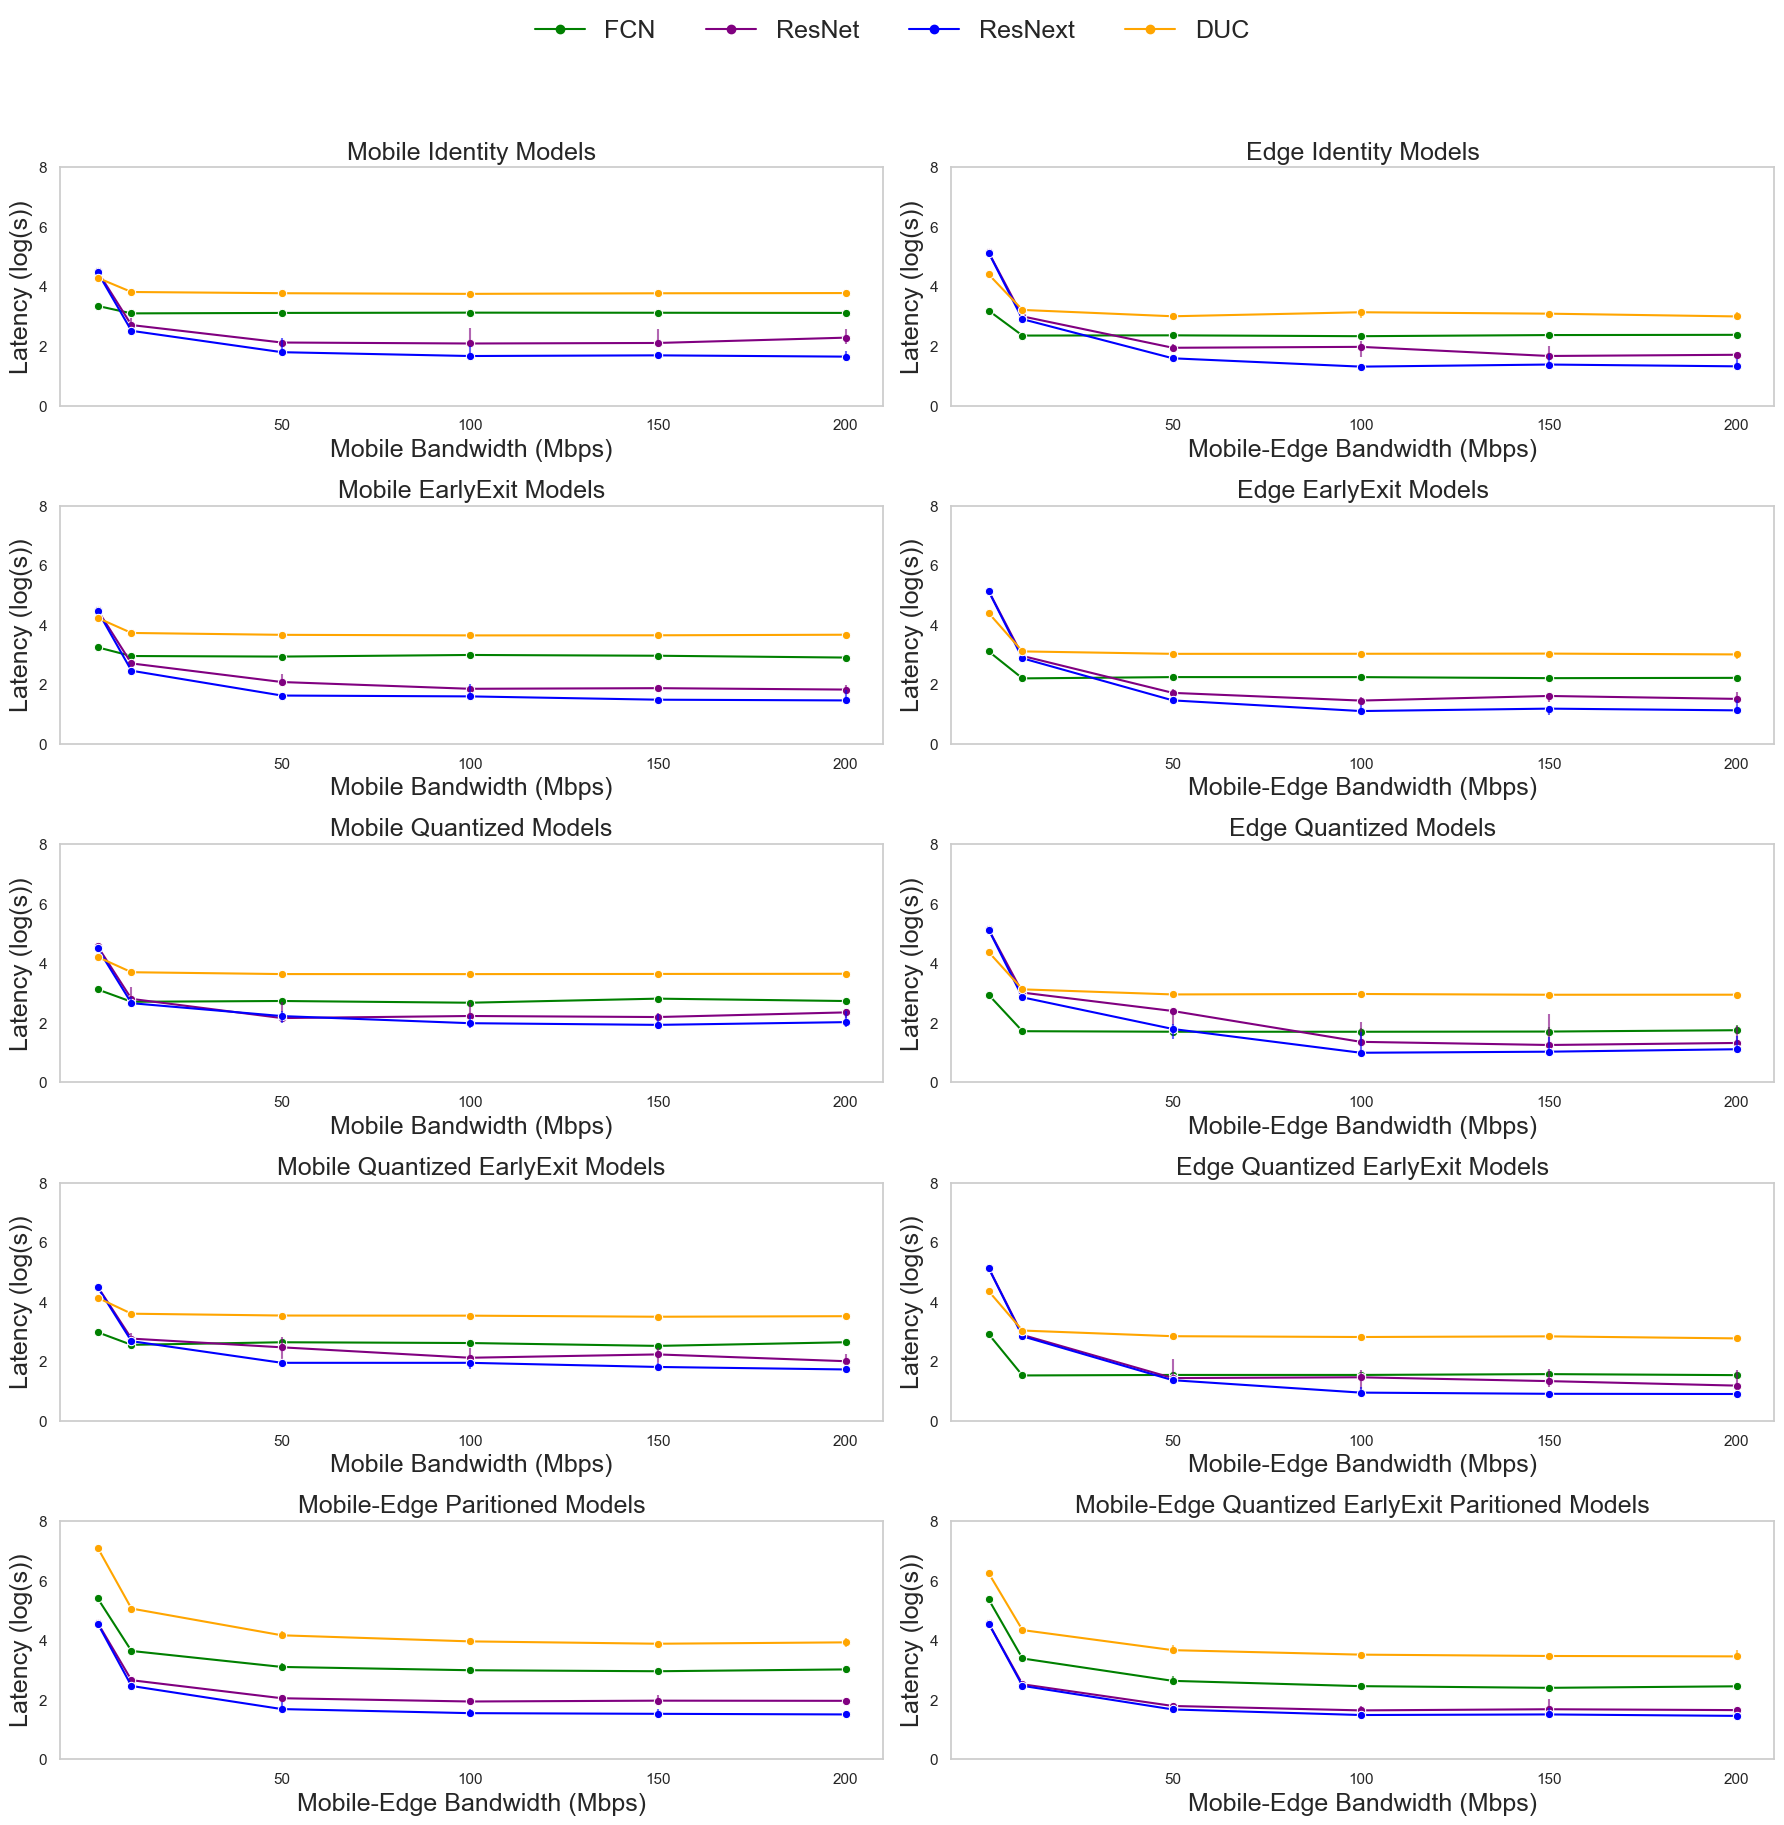

In [18]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()[1:]
            latencies = [float(line.strip()) for line in lines if line.strip()]
            return latencies[-5:] if len(latencies) >= 5 else latencies
    except (IOError, ValueError) as e:
        print(f"Error reading or parsing {file_path}: {e}")
        return []

# Define folder paths for all models
folder_paths = {
    "mobile_fcn": "mobile_fcn",
    "mobile_resnet": "mobile_resnet",
    "mobile_resnext": "mobile_resnext",
    "mobile_duc": "mobile_duc",
    "edge_fcn": "edge_fcn",
    "edge_resnet": "edge_resnet",
    "edge_resnext": "edge_resnext",
    "edge_duc": "edge_duc",
    "mobile_fcn_earlyexit": "mobile_fcn_earlyexit",
    "mobile_resnet_earlyexit": "mobile_resnet_earlyexit",
    "mobile_resnext_earlyexit": "mobile_resnext_earlyexit",
    "mobile_duc_earlyexit": "mobile_duc_earlyexit",
    "edge_fcn_earlyexit": "edge_fcn_earlyexit",
    "edge_resnet_earlyexit": "edge_resnet_earlyexit",
    "edge_resnext_earlyexit": "edge_resnext_earlyexit",
    "edge_duc_earlyexit": "edge_duc_earlyexit",
    "mobile_fcn_int8_sptq": "mobile_fcn_int8_sptq",
    "mobile_resnet_int8_sptq": "mobile_resnet_int8_sptq",
    "mobile_resnext_int8_sptq": "mobile_resnext_int8_sptq",
    "mobile_duc_int8_sptq": "mobile_duc_int8_sptq",
    "edge_fcn_int8_sptq": "edge_fcn_int8_sptq",
    "edge_resnet_int8_sptq": "edge_resnet_int8_sptq",
    "edge_resnext_int8_sptq": "edge_resnext_int8_sptq",
    "edge_duc_int8_sptq": "edge_duc_int8_sptq",
    "mobile_fcn_earlyexit_int8_sptq": "mobile_fcn_earlyexit_int8_sptq",
    "mobile_resnet_earlyexit_int8_sptq": "mobile_resnet_earlyexit_int8_sptq",
    "mobile_resnext_earlyexit_int8_sptq": "mobile_resnext_earlyexit_int8_sptq",
    "mobile_duc_earlyexit_int8_sptq": "mobile_duc_earlyexit_int8_sptq",
    "edge_fcn_earlyexit_int8_sptq": "edge_fcn_earlyexit_int8_sptq",
    "edge_resnet_earlyexit_int8_sptq": "edge_resnet_earlyexit_int8_sptq",
    "edge_resnext_earlyexit_int8_sptq": "edge_resnext_earlyexit_int8_sptq",
    "edge_duc_earlyexit_int8_sptq": "edge_duc_earlyexit_int8_sptq",
    "mobile_edge_fcn": "mobile_edge_fcn",
    "mobile_edge_resnet": "mobile_edge_resnet",
    "mobile_edge_resnext": "mobile_edge_resnext",
    "mobile_edge_duc": "mobile_edge_duc",
    "mobile_edge_fcn_earlyexit_int8_sptq": "mobile_edge_fcn_earlyexit_int8_sptq",
    "mobile_edge_resnet_earlyexit_int8_sptq": "mobile_edge_resnet_earlyexit_int8_sptq",
    "mobile_edge_resnext_earlyexit_int8_sptq": "mobile_edge_resnext_earlyexit_int8_sptq",
    "mobile_edge_duc_earlyexit_int8_sptq": "mobile_edge_duc_earlyexit_int8_sptq",
}

# Categorize models
standard_mobile_models = ["mobile_fcn", "mobile_resnet", "mobile_resnext", "mobile_duc"]
standard_edge_models = ["edge_fcn", "edge_resnet", "edge_resnext", "edge_duc"]
earlyexit_mobile_models = ["mobile_fcn_earlyexit", "mobile_resnet_earlyexit", "mobile_resnext_earlyexit", "mobile_duc_earlyexit"]
earlyexit_edge_models = ["edge_fcn_earlyexit", "edge_resnet_earlyexit", "edge_resnext_earlyexit", "edge_duc_earlyexit"]
quantized_mobile_models = ["mobile_fcn_int8_sptq", "mobile_resnet_int8_sptq", "mobile_resnext_int8_sptq", "mobile_duc_int8_sptq"]
quantized_edge_models = ["edge_fcn_int8_sptq", "edge_resnet_int8_sptq", "edge_resnext_int8_sptq", "edge_duc_int8_sptq"]
quantized_earlyexit_mobile_models = ["mobile_fcn_earlyexit_int8_sptq", "mobile_resnet_earlyexit_int8_sptq", "mobile_resnext_earlyexit_int8_sptq", "mobile_duc_earlyexit_int8_sptq"]
quantized_earlyexit_edge_models = ["edge_fcn_earlyexit_int8_sptq", "edge_resnet_earlyexit_int8_sptq", "edge_resnext_earlyexit_int8_sptq", "edge_duc_earlyexit_int8_sptq"]
partitioned_mobile_edge_models = ["mobile_edge_fcn", "mobile_edge_resnet", "mobile_edge_resnext", "mobile_edge_duc"]
quantized_earlyexit_partitioned_mobile_edge_models = ["mobile_edge_fcn_earlyexit_int8_sptq", "mobile_edge_resnet_earlyexit_int8_sptq", "mobile_edge_resnext_earlyexit_int8_sptq", "mobile_edge_duc_earlyexit_int8_sptq"]

# Combine all models into one set
all_models = (
    standard_mobile_models + standard_edge_models +
    earlyexit_mobile_models + earlyexit_edge_models +
    quantized_mobile_models + quantized_edge_models + 
    quantized_earlyexit_mobile_models + quantized_earlyexit_edge_models +
    partitioned_mobile_edge_models + quantized_earlyexit_partitioned_mobile_edge_models
)

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in all_models}

# Predefined set of mobile-edge bandwidths
mobile_edge_bandwidths = [1, 10, 50, 100, 150, 200]

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            parts = filename.split("_")
            if "earlyexit" in model and "earlyexit_int8_sptq" not in model:
                mobile_edge_bw = int(parts[3].replace("mbps", ""))
            elif "int8_sptq" in model and "earlyexit_int8_sptq" not in model:
                mobile_edge_bw = int(parts[4].replace("mbps", ""))
            elif "earlyexit_int8_sptq" in model and "mobile_edge" not in model:
                mobile_edge_bw = int(parts[5].replace("mbps", ""))
            elif "mobile_edge" in model and "earlyexit_int8_sptq" not in model:
                mobile_edge_bw = int(parts[3].replace("mbps", ""))
            elif "mobile_edge" in model and "earlyexit_int8_sptq" in model:
                mobile_edge_bw = int(parts[6].replace("mbps", ""))
            else:
                mobile_edge_bw = int(parts[2].replace("mbps", ""))
            
            if mobile_edge_bw in mobile_edge_bandwidths:
                file_path = os.path.join(folder_path, filename)
                latencies = extract_last_5_latencies(file_path)
                if mobile_edge_bw not in latency_data[model]:
                    latency_data[model][mobile_edge_bw] = []
                latency_data[model][mobile_edge_bw].append(latencies)

# Colors and labels for models
# Colors for the models
model_colors = {
    "mobile_fcn": "green",
    "mobile_resnet": "purple",
    "mobile_resnext": "blue",
    "mobile_duc": "orange",
    "edge_fcn": "green",  
    "edge_resnet": "purple",
    "edge_resnext": "blue",
    "edge_duc": "orange",
    "mobile_fcn_earlyexit": "green",
    "mobile_resnet_earlyexit": "purple",
    "mobile_resnext_earlyexit": "blue",
    "mobile_duc_earlyexit": "orange",
    "edge_fcn_earlyexit": "green",
    "edge_resnet_earlyexit": "purple",
    "edge_resnext_earlyexit": "blue",
    "edge_duc_earlyexit": "orange",
    "mobile_fcn_int8_sptq": "green",
    "mobile_resnet_int8_sptq": "purple",
    "mobile_resnext_int8_sptq": "blue",
    "mobile_duc_int8_sptq": "orange",
    "edge_fcn_int8_sptq": "green",
    "edge_resnet_int8_sptq": "purple",
    "edge_resnext_int8_sptq": "blue",
    "edge_duc_int8_sptq": "orange",
    "mobile_fcn_earlyexit_int8_sptq": "green",
    "mobile_resnet_earlyexit_int8_sptq": "purple",
    "mobile_resnext_earlyexit_int8_sptq": "blue",
    "mobile_duc_earlyexit_int8_sptq": "orange",
    "edge_fcn_earlyexit_int8_sptq": "green",
    "edge_resnet_earlyexit_int8_sptq": "purple",
    "edge_resnext_earlyexit_int8_sptq": "blue",
    "edge_duc_earlyexit_int8_sptq": "orange",
    "mobile_edge_fcn": "green",
    "mobile_edge_resnet": "purple",
    "mobile_edge_resnext": "blue",
    "mobile_edge_duc": "orange",
    "mobile_edge_fcn_earlyexit_int8_sptq": "green",
    "mobile_edge_resnet_earlyexit_int8_sptq": "purple",
    "mobile_edge_resnext_earlyexit_int8_sptq": "blue",
    "mobile_edge_duc_earlyexit_int8_sptq": "orange",
}
legend_labels = {
    "fcn": "FCN",
    "resnet": "ResNet",
    "resnext": "ResNext",
    "duc": "DUC"
}

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(18, 18))

# Function to plot data
def plot_data(models, title, ax, ylim):
    if title=="Mobile Identity Models" or title=="Mobile EarlyExit Models" or title=="Mobile Quantized Models" or title=="Mobile Quantized EarlyExit Models":
        for model in models:
            medians, mins, maxs = [], [], []
            for mobile_bw in mobile_edge_bandwidths:
                if mobile_bw in latency_data[model]:
                    latencies = latency_data[model][mobile_bw]
                    medians.append(np.log(np.median(latencies)))
                    mins.append(np.log(np.min(latencies)))
                    maxs.append(np.log(np.max(latencies)))
            sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
            for j in range(len(medians)):
                ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
        ax.set_xticks([50, 100, 150, 200])
        ax.set_ylim(0, 8)
        ax.set_xlabel('Mobile Bandwidth (Mbps)',fontsize=18)
        ax.set_ylabel('Latency (log(s))',fontsize=18)
        ax.set_title(title,fontsize=18)
        ax.grid(False)
    else:
        for model in models:
            medians, mins, maxs = [], [], []
            for mobile_bw in mobile_edge_bandwidths:
                if mobile_bw in latency_data[model]:
                    latencies = latency_data[model][mobile_bw]
                    medians.append(np.log(np.median(latencies)))
                    mins.append(np.log(np.min(latencies)))
                    maxs.append(np.log(np.max(latencies)))
            sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
            for j in range(len(medians)):
                ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
        ax.set_xticks([50, 100, 150, 200])
        ax.set_ylim(0, 8)
        ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)',fontsize=18)
        ax.set_ylabel('Latency (log(s))',fontsize=18)
        ax.set_title(title,fontsize=18)
        ax.grid(False)

# Plot categories
plot_data(standard_mobile_models, "Mobile Identity Models", axs[0, 0], ylim=50)
plot_data(standard_edge_models, "Edge Identity Models", axs[0, 1], ylim=50)
plot_data(earlyexit_mobile_models, "Mobile EarlyExit Models", axs[1, 0], ylim=50)
plot_data(earlyexit_edge_models, "Edge EarlyExit Models", axs[1, 1], ylim=50)
plot_data(quantized_mobile_models, "Mobile Quantized Models", axs[2, 0], ylim=50)
plot_data(quantized_edge_models, "Edge Quantized Models", axs[2, 1], ylim=50)
plot_data(quantized_earlyexit_mobile_models, "Mobile Quantized EarlyExit Models", axs[3, 0], ylim=50)
plot_data(quantized_earlyexit_edge_models, "Edge Quantized EarlyExit Models", axs[3, 1], ylim=50)
plot_data(partitioned_mobile_edge_models, "Mobile-Edge Paritioned Models", axs[4, 0], ylim=160)
plot_data(quantized_earlyexit_partitioned_mobile_edge_models, "Mobile-Edge Quantized EarlyExit Paritioned Models", axs[4, 1], ylim=160)
# Adjust layout and create a common legend
fig.tight_layout(rect=[0, 0, 1, 0.95])
handles = [
    plt.Line2D([0], [0], color="green", marker='o', linestyle='-', label=legend_labels["fcn"]),
    plt.Line2D([0], [0], color="purple", marker='o', linestyle='-', label=legend_labels["resnet"]),
    plt.Line2D([0], [0], color="blue", marker='o', linestyle='-', label=legend_labels["resnext"]),
    plt.Line2D([0], [0], color="orange", marker='o', linestyle='-', label=legend_labels["duc"]),
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), frameon=False,fontsize=18)
plt.savefig('mobile_edge_latency.png', dpi=300)
# Save and display the plot
fig.savefig('mobile_edge_latency.pdf', bbox_inches='tight',format='pdf')
plt.show()